- n_fits = 1 バージョン
- 推定が上手くいっていない. やはり複数の初期値で試すのが重要か

In [6]:
import numpy as np
import hmmlearn.hmm as hmm
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Model #0's score: -1728.1300608139456
Generated score: -1697.4114608887376
Best score:      -1728.1300608139456 (model #0)


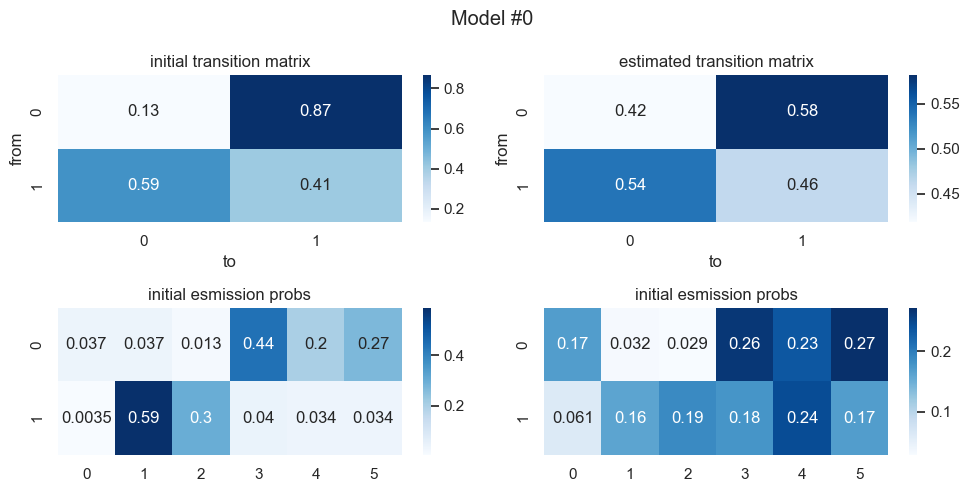

In [7]:
np.random.seed(42)

gen_model = hmm.CategoricalHMM(n_components=2, random_state=42)
gen_model.startprob_ = np.array([1.0, 0.0])
gen_model.transmat_ = np.array([[0.9, 0.1], [0.2, 0.8]])
gen_model.emissionprob_ = np.array([
        [1/6]*6,  # fair dice
        [0, 0, 0, 1/3, 1/3, 1/3]  # loaded dice
        ])

X, Z = gen_model.sample(1000)

gen_score = gen_model.score(X)

n_fits = 1
best_score = best_model = best_idx= None
for i in range(n_fits):
    model = hmm.CategoricalHMM(n_components=2, random_state=42, init_params="s")
    model.transmat_ = np.array([
        np.random.dirichlet([1, 1]), np.random.dirichlet([1, 1])
        ])
    model.emissionprob_ = np.array([
        np.random.dirichlet([1]*6), np.random.dirichlet([1]*6)
        ])
    initial_transmat = model.transmat_
    initial_esmissionprob = model.emissionprob_
    model.fit(X)
    estimated_transmat = model.transmat_
    estimated_esmissionprob = model.emissionprob_
    # plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    axs = axs.flatten()
    sns.heatmap(initial_transmat, annot=True, cmap="Blues", ax=axs[0])
    axs[0].set_xlabel("to")
    axs[0].set_ylabel("from")
    axs[0].set_title("initial transition matrix")
    sns.heatmap(estimated_transmat, annot=True, cmap="Blues", ax=axs[1])
    axs[1].set_xlabel("to")
    axs[1].set_ylabel("from")
    axs[1].set_title("estimated transition matrix")
    sns.heatmap(initial_esmissionprob, annot=True, cmap="Blues", ax=axs[2])
    axs[2].set_title("initial esmission probs")
    sns.heatmap(estimated_esmissionprob, annot=True, cmap="Blues", ax=axs[3])
    axs[3].set_title("initial esmission probs")
    fig.suptitle(f"Model #{i}")
    fig.tight_layout()
    score = model.score(X)
    print(f"Model #{i}'s score: {score}")
    if best_score is None or score > best_score:
        best_model = model
        best_score = score
        best_idx = i

print(f'Generated score: {gen_score}\nBest score:      {best_score} (model #{best_idx})')


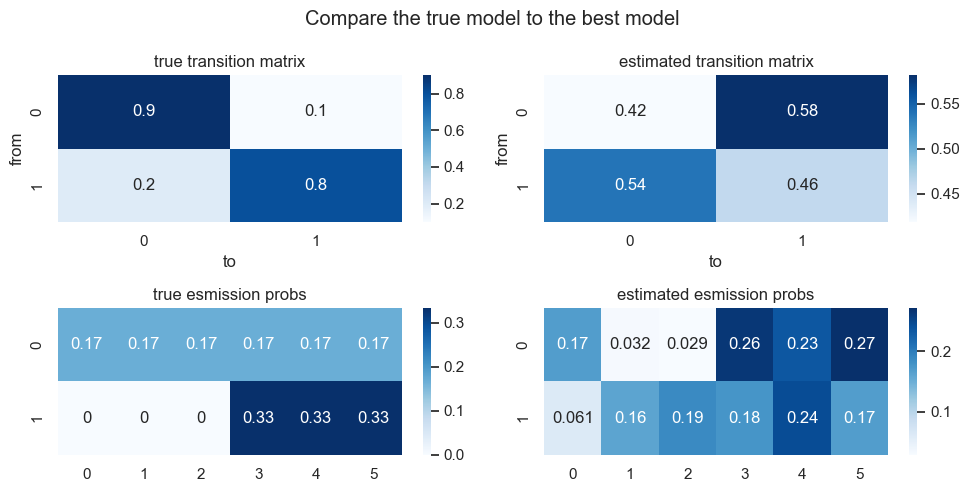

In [8]:
# compare best model to true model
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()
sns.heatmap(gen_model.transmat_, annot=True, cmap="Blues", ax=axs[0])
axs[0].set_xlabel("to")
axs[0].set_ylabel("from")
axs[0].set_title("true transition matrix")
sns.heatmap(best_model.transmat_, annot=True, cmap="Blues", ax=axs[1])
axs[1].set_xlabel("to")
axs[1].set_ylabel("from")
axs[1].set_title("estimated transition matrix")
sns.heatmap(gen_model.emissionprob_, annot=True, cmap="Blues", ax=axs[2])
axs[2].set_title("true esmission probs")
sns.heatmap(best_model.emissionprob_, annot=True, cmap="Blues", ax=axs[3])
axs[3].set_title("estimated esmission probs")
fig.suptitle(f"Compare the true model to the best model")
fig.tight_layout()


stateが逆に出ているようなので, 反転させて比較する.  
- state 0: 通常サイコロ
- state 1: いかさまサイコロ

Text(0.5, 1.0, 'Confusion matrix')

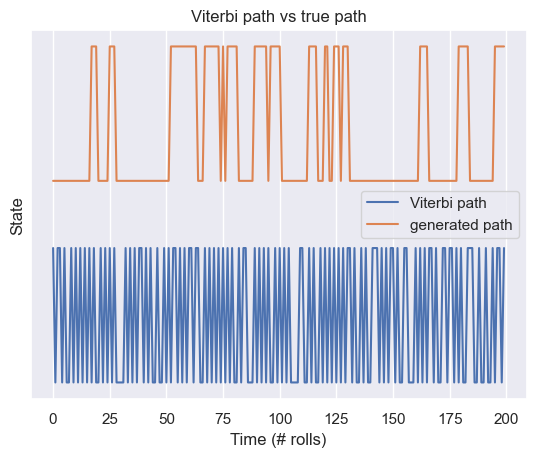

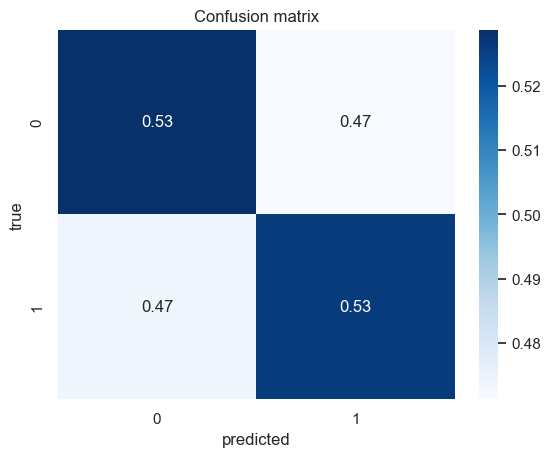

In [9]:
# best modelでViterbi pathを計算
viterbi_path = best_model.predict(X)

Z = Z.astype(bool)
viterbi_path = viterbi_path.astype(bool)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(~viterbi_path[:200], label='Viterbi path')
ax.plot(Z[:200]+ 1.5, label='generated path')
ax.set_yticks([])
ax.set_title('Viterbi path vs true path')
ax.set_xlabel('Time (# rolls)')
ax.set_ylabel('State')
ax.legend()

from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(Z, ~viterbi_path, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, cmap="Blues", ax=ax)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_title("Confusion matrix")



- 本当にイカサマしてるときはだいたい見破れる
- ただしイカサマしてないときにもイカサマ指摘してしまうことが結構ある

Text(0.5, 1.0, 'Confusion matrix')

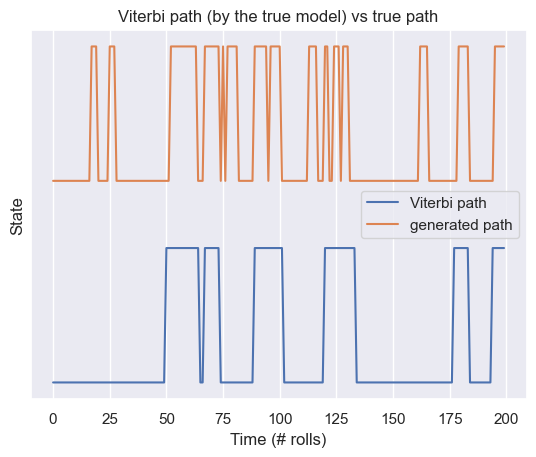

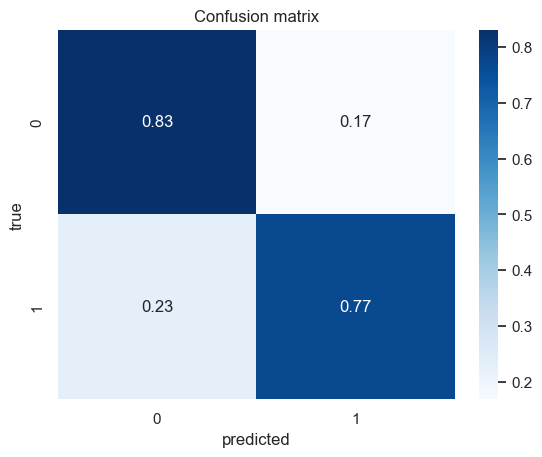

In [10]:
# true modelで計算したViterbi path
# best modelでViterbi pathを計算
viterbi_path = gen_model.predict(X)

Z = Z.astype(bool)
viterbi_path = viterbi_path.astype(bool)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(viterbi_path[:200], label='Viterbi path')
ax.plot(Z[:200]+ 1.5, label='generated path')
ax.set_yticks([])
ax.set_title('Viterbi path (by the true model) vs true path')
ax.set_xlabel('Time (# rolls)')
ax.set_ylabel('State')
ax.legend()

from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(Z, viterbi_path, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, cmap="Blues", ax=ax)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_title("Confusion matrix")
